In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [3]:
basis = "6-311++g**"
#basis = "sto-3g"
#model_path="../../models/DescriptorC/" + target + "/"

In [4]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"

data = Data()

In [ ]:
from pyscf.scf import hf



#data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)

molecules = np.load("../butadien/data/400/molecules400.npy")
S = np.load("../butadien/data/400/S400.npy")
P = np.load("../butadien/data/400/P400.npy")

p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules
])

dim = 26
species = "C"

data._package_and_append(S, P-p_gwh.reshape(*P.shape), molecules, 0.8, 0.8)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

In [5]:
from pyscf.scf import hf

#data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)

molecules = np.load("../butadien/data/400/molecules400_" + basis + ".npy")
S = np.load("../butadien/data/400/S400_" + basis + ".npy")
P = np.load("../butadien/data/400/P400_" + basis + ".npy")

p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules
])

dim = 130
species = "C"

data._package_and_append(S, P - p_gwh, molecules, 0.8, 0.8)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

# Classical  

In [6]:
dim = 130

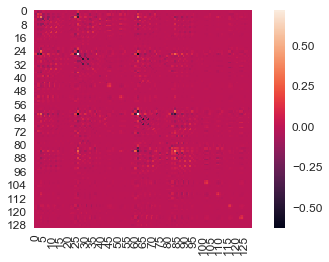

In [7]:
sns.heatmap(data.T[0][0].reshape(dim, dim), square=True)

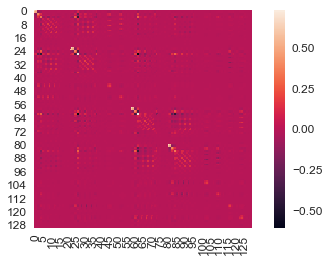

In [8]:
sns.heatmap(P[0].reshape(dim, dim), square=True)

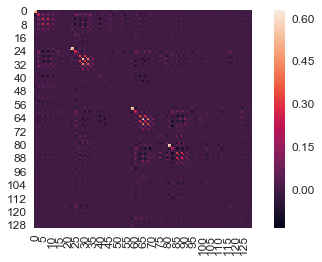

In [9]:
sns.heatmap(p_gwh[0], square=True)

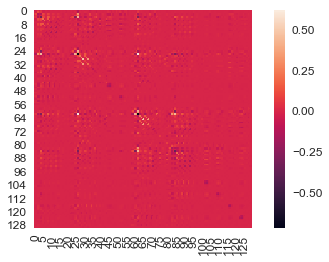

In [10]:
sns.heatmap(p_gwh[0] - P[0].reshape(dim, dim), square=True)

In [44]:
np.max(np.abs(p_gwh[0].reshape(dim**2) - P[0].reshape(dim**2)))

0.7165520426659467

# Descriptor 

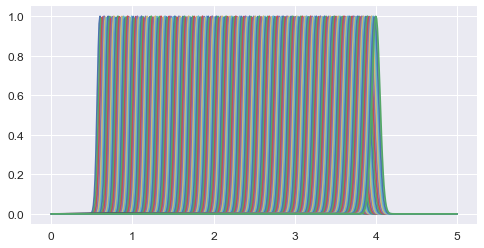

In [11]:
#from SCFInitialGuess.descriptors.models import make_uniform

def plot_normal_model(model, t):
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t, np.exp(-1 * eta*(t - r_s)**2))

def make_uniform(n, R_c=5, eta_max=30, eta_min=10):
    return (
        np.linspace(0.6,R_c*0.8, n),
        np.linspace(eta_max, eta_min, n),
    )
        
model = make_uniform(n=200, R_c=5, eta_min=200, eta_max=500)
#model = make_uniform(n=50, R_c=5, eta_min=100, eta_max=30)
plot_normal_model(model, np.linspace(0, 5, 500))

In [12]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
import pickle

descriptor = AtomicNumberWeighted(
    #Gaussians(*RADIAL_GAUSSIAN_MODELS["Man"]),
    #Gaussians(*make_uniform(150, eta_max=200, eta_min=30)),
    Gaussians(*model),
    SPHAngularDescriptor(8),
    BehlerCutoff1(5)
)

#pickle.dump(descriptor, open(model_path + "descriptor.dump", "wb"))
    
descriptor.radial_descriptor.number_of_descriptors, descriptor.angular_descriptor.number_of_descriptors, descriptor.number_of_descriptors

(200, 162, 362)

In [13]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
index=200
f = lambda x: x#(x[0][:index], x[0][index:(2*index)], x[2])

dataset_C = make_center_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "C"
)

#np.save(model_path + "normalisation.npy", (dataset_C.x_mean, dataset_C.x_std))


In [14]:
np.mean(dataset_C.testing[1][0])

-0.0026304427957247723

In [15]:
len(dataset_C.training[0]), len(dataset_C.validation[0]), len(dataset_C.testing[0]), 

(1024, 256, 324)

In [16]:
from SCFInitialGuess.utilities.dataset import AbstractDataset

x_train = AbstractDataset.denormalize(dataset_C.training[0], dataset_C.x_mean, dataset_C.x_std)
y_train = dataset_C.training[1]
np.mean(x_train[0] - x_train[-1])

-0.02151688998783505

## Variance over time 

### Not normed 

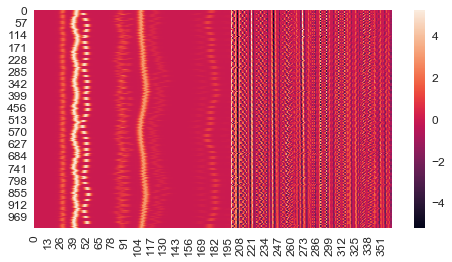

In [17]:
sns.heatmap(x_train)

### Normed 

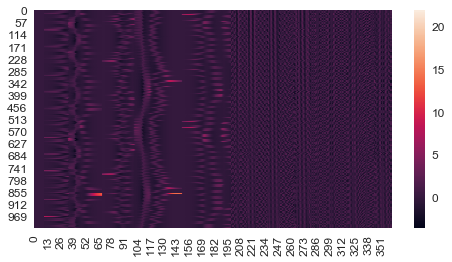

In [18]:
sns.heatmap(dataset_C.training[0])

### Output 

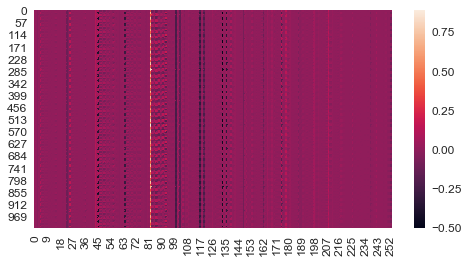

In [19]:
sns.heatmap(dataset_C.training[1])

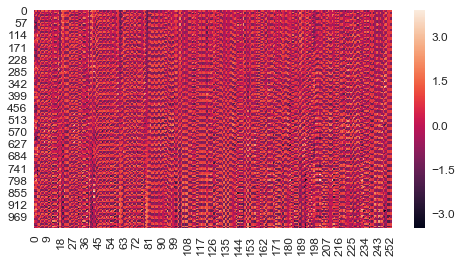

In [20]:
sns.heatmap(AbstractDataset.normalize(dataset_C.training[1])[0])

In [21]:
from SCFInitialGuess.utilities.dataset import AbstractDataset

dataset = dataset_C

_, y_mu, y_std = AbstractDataset.normalize(
    list(dataset_C.training[1]) + \
    list(dataset_C.validation[1]) + \
    list(dataset_C.testing[1])
)

dataset.training = (dataset_C.training[0], AbstractDataset.normalize(dataset_C.training[1], mean=y_mu, std=y_std)[0])
dataset.validation = (dataset_C.validation[0], AbstractDataset.normalize(dataset_C.validation[1], mean=y_mu, std=y_std)[0])
dataset.testing = (dataset_C.testing[0], AbstractDataset.normalize(dataset_C.testing[1], mean=y_mu, std=y_std)[0])


## Variance

In [22]:
np.var(x_train, 0).shape

(362,)

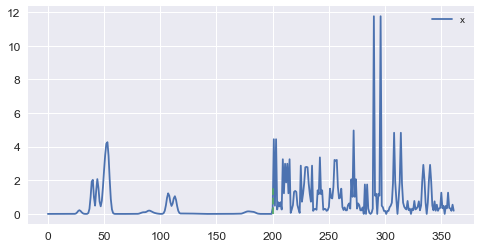

In [23]:
offset=0
plt.plot(np.var(x_train, 0)[offset:], label="x")
plt.plot([descriptor.radial_descriptor.number_of_descriptors - offset]*2, [1e-3, 1.6], "--")

plt.legend()

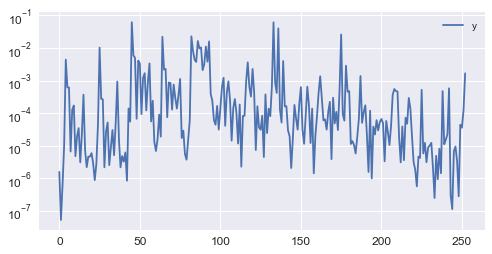

In [24]:
plt.semilogy(np.var(y_train, 0), label="y")
plt.legend()

# Average 

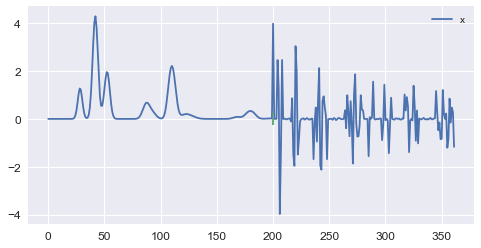

In [25]:
plt.plot(np.mean(x_train, 0), label="x")
plt.plot([descriptor.radial_descriptor.number_of_descriptors]*2, [-0.25, 0.25], "--")

plt.legend()

# Network Stuff 

In [26]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            #kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(1e-4)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [27]:
#path = model_path

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath, learning_rate=1e-4, log_dir="./logs"):

    """
    tensorboard = keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=0, 
        batch_size=32, 
        #update_freq='epoch'
    )
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_mean_squared_error', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1
    )
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                #checkpoint,
                #tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

# Actucal training 

In [28]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(1024, 256, 324)

In [29]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS


species = "C"

dim_C = N_BASIS[basis][species]
dim_C_triu = dim_C * (dim_C + 1) // 2


In [30]:
descriptor.number_of_descriptors, dim_C_triu

(362, 253)

In [45]:
#structure_C = [200, 100, 50]
structure_C = [500, 400, 300]

In [46]:
keras.backend.clear_session()

In [47]:
model_C = make_model(
    structure=structure_C,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_C_triu,
    
)

model_C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               181500    
_________________________________________________________________
dense_1 (Dense)              (None, 400)               200400    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_3 (Dense)              (None, 253)               76153     
Total params: 578,353
Trainable params: 578,353
Non-trainable params: 0
_________________________________________________________________


In [48]:
i =0
name_C = "C_" + target + ".h5"
name = "F/500-10"

Train on 1024 samples, validate on 256 samples
Epoch 1/1000
1024/1024 [==============================] - 0s 470us/step - loss: 0.6636 - mean_squared_error: 0.5848 - val_loss: 0.7586 - val_mean_squared_error: 0.6798
Epoch 2/1000
1024/1024 [==============================] - 0s 192us/step - loss: 0.2963 - mean_squared_error: 0.2175 - val_loss: 0.6325 - val_mean_squared_error: 0.5537
Epoch 3/1000
1024/1024 [==============================] - 0s 181us/step - loss: 0.1964 - mean_squared_error: 0.1178 - val_loss: 0.5693 - val_mean_squared_error: 0.4909
Epoch 4/1000
1024/1024 [==============================] - 0s 189us/step - loss: 0.1722 - mean_squared_error: 0.0940 - val_loss: 0.5279 - val_mean_squared_error: 0.4500
Epoch 5/1000
1024/1024 [==============================] - 0s 187us/step - loss: 0.1597 - mean_squared_error: 0.0821 - val_loss: 0.4877 - val_mean_squared_error: 0.4104
Epoch 6/1000
1024/1024 [==============================] - 0s 177us/step - loss: 0.1501 - mean_squared_error: 0.07

1024/1024 [==============================] - 0s 177us/step - loss: 0.0513 - mean_squared_error: 0.0076 - val_loss: 0.1726 - val_mean_squared_error: 0.1293
Epoch 50/1000
1024/1024 [==============================] - 0s 164us/step - loss: 0.0505 - mean_squared_error: 0.0075 - val_loss: 0.1698 - val_mean_squared_error: 0.1271
Epoch 51/1000
1024/1024 [==============================] - 0s 171us/step - loss: 0.0495 - mean_squared_error: 0.0072 - val_loss: 0.1701 - val_mean_squared_error: 0.1282
Epoch 52/1000
1024/1024 [==============================] - 0s 170us/step - loss: 0.0487 - mean_squared_error: 0.0071 - val_loss: 0.1681 - val_mean_squared_error: 0.1269
Epoch 53/1000
1024/1024 [==============================] - 0s 170us/step - loss: 0.0479 - mean_squared_error: 0.0070 - val_loss: 0.1675 - val_mean_squared_error: 0.1270
Epoch 54/1000
1024/1024 [==============================] - 0s 176us/step - loss: 0.0470 - mean_squared_error: 0.0068 - val_loss: 0.1656 - val_mean_squared_error: 0.1258


1024/1024 [==============================] - 0s 196us/step - loss: 0.0344 - mean_squared_error: 0.0045 - val_loss: 0.1507 - val_mean_squared_error: 0.1208
Epoch 96/1000
1024/1024 [==============================] - 0s 183us/step - loss: 0.0344 - mean_squared_error: 0.0045 - val_loss: 0.1507 - val_mean_squared_error: 0.1208
Epoch 97/1000
1024/1024 [==============================] - 0s 187us/step - loss: 0.0344 - mean_squared_error: 0.0045 - val_loss: 0.1507 - val_mean_squared_error: 0.1208

Epoch 00097: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 98/1000
1024/1024 [==============================] - 0s 199us/step - loss: 0.0344 - mean_squared_error: 0.0045 - val_loss: 0.1507 - val_mean_squared_error: 0.1208
Epoch 00098: early stopping
Train on 1024 samples, validate on 256 samples
Epoch 1/1000
1024/1024 [==============================] - 0s 173us/step - loss: 0.0344 - mean_squared_error: 0.0048 - val_loss: 0.1489 - val_mean_squared_error: 0.1196
Epoch 2/1000
1024/1024 [======

1024/1024 [==============================] - 0s 197us/step - loss: 0.0279 - mean_squared_error: 0.0035 - val_loss: 0.1437 - val_mean_squared_error: 0.1194
Epoch 20/1000
1024/1024 [==============================] - 0s 171us/step - loss: 0.0279 - mean_squared_error: 0.0035 - val_loss: 0.1437 - val_mean_squared_error: 0.1194

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
Epoch 21/1000
1024/1024 [==============================] - 0s 188us/step - loss: 0.0279 - mean_squared_error: 0.0035 - val_loss: 0.1437 - val_mean_squared_error: 0.1194
Epoch 00021: early stopping
Train on 1024 samples, validate on 256 samples
Epoch 1/1000
1024/1024 [==============================] - 0s 196us/step - loss: 0.0279 - mean_squared_error: 0.0038 - val_loss: 0.1426 - val_mean_squared_error: 0.1189
Epoch 2/1000
1024/1024 [==============================] - 0s 187us/step - loss: 0.0273 - mean_squared_error: 0.0039 - val_loss: 0.1411 - val_mean_squared_error: 0.1180
Epoch 3/1000
10

 352/1024 [=========>....................] - ETA: 0s - loss: 0.0206 - mean_squared_error: 0.0024

KeyboardInterrupt: 

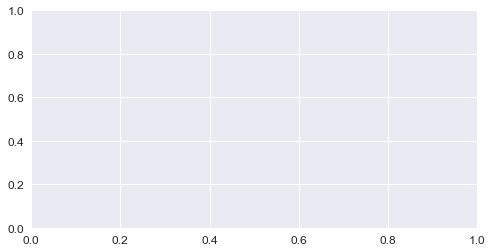

In [49]:
path=""
i+=1
train_model(
    model_C, 
    dataset_C, 
    path + name_C,
    learning_rate=1e-4,
    #log_dir="./logs/C/" + "all_" + str(i)
    log_dir="./logs/C/" + name + "_" + "x".join(list(map(str, structure_C))) + "_" + str(i)
)

In [ ]:
error